In [123]:
import pandas as pd
import os
from matplotlib import pyplot
import matplotlib.colors as mcolors
import matplotlib
import math
from matplotlib.pyplot import figure
import pyarrow as pa
import pyarrow.parquet as pq
import numpy as np
from google.cloud import storage
from google.cloud.storage import Blob

In [124]:
dir_files = [n.split('.')[0] for n in os.listdir('/home/jupyter/pss/tmp/') if not n in ['.ipynb_checkpoints', 'Untitled.ipynb', 'TMalign.cpp', 'blast_annotations.parquet']]
res = pd.DataFrame(None)
for file in dir_files:
    res = res.append(pd.read_parquet(f'/home/jupyter/pss/tmp/{file}.parquet'))
print('Experiment:', len(res), 'out of 19272 processed')

Experiment: 19247 out of 19272 processed


In [125]:
print('Highest number of processed protein pairs per cluster')
print(res[['cluster', 'target_protein']].groupby(['cluster']).count().reset_index().sort_values(by=['target_protein'], ascending=False)[:5])
print('\nHighest mean tmalign scores for processed pairs by cluster')
print(res[['cluster', 'tmalign_score']].groupby(['cluster']).mean(['tmalign_score']).reset_index().sort_values(by=['tmalign_score'], ascending=False)[:5])

Highest number of processed protein pairs per cluster
    cluster  target_protein
0        -1            2520
4        19            2486
6        28            2429
15      107            2308
31      329            1994

Highest mean tmalign scores for processed pairs by cluster
    cluster  tmalign_score
38      441       0.908596
2        11       0.885108
41      721       0.884817
1         3       0.858178
10       46       0.857415


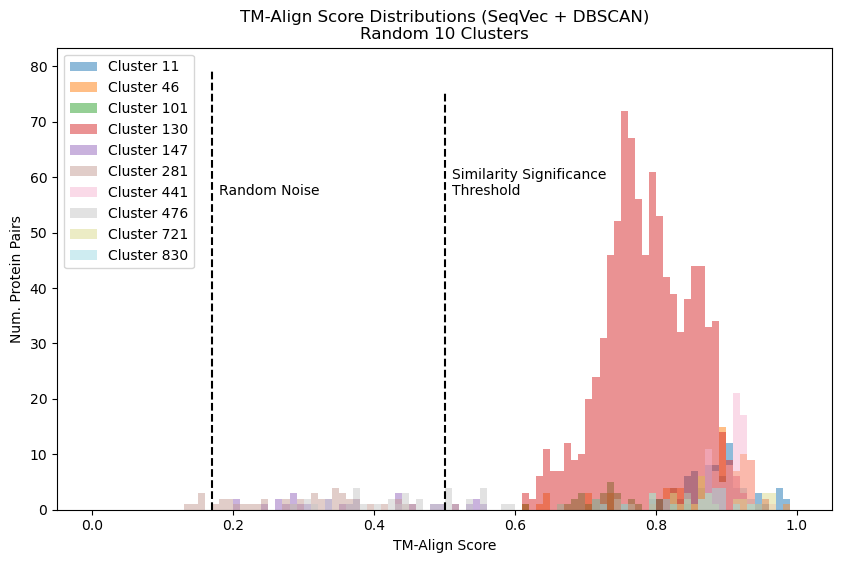

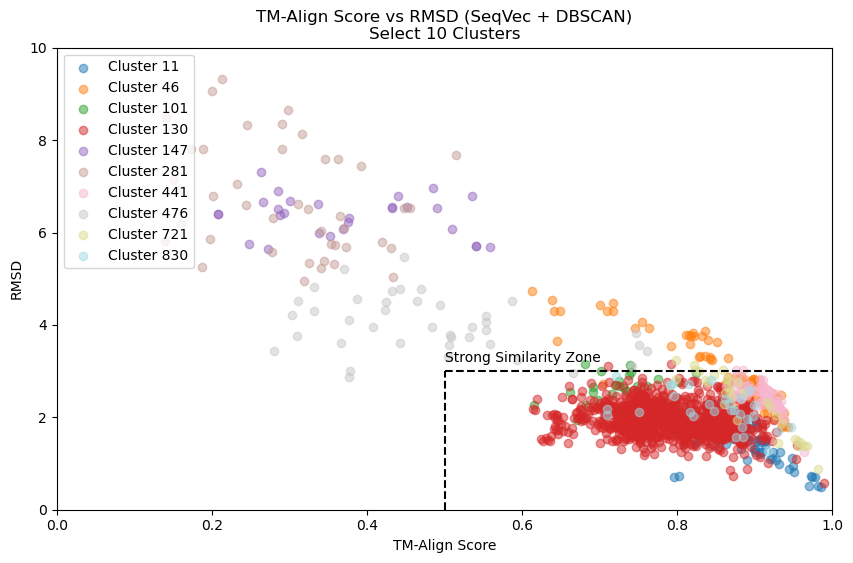

In [126]:
from utils import model_and_evaluate_cluster as ev

cmap = 'tab20'
name = f"SeqVec + DBSCAN"

plot_1_clusters = ev.tmalign_hist(res, version='random', num_results=10, cmap=cmap, name=name)
plot_2_clusters = ev.tmalign_scatter(res[res.cluster.isin(plot_1_clusters)], cmap=cmap, name=name)

In [127]:
print(len(res))
res.head()

19247


,query_protein,query_protein_length,target_protein,target_protein_length,aligned_length,rmsd,tmalign_score,cluster
0,AF-Q5VU43-F1-model_v1,2346,AF-Q5SQ80-F1-model_v1,823,306,7.73,0.10499,107
1,AF-O60602-F1-model_v1,858,AF-Q99983-F1-model_v1,421,333,4.29,0.34230,254
2,AF-Q8TF50-F1-model_v1,670,AF-Q8N7K0-F1-model_v1,673,276,6.29,0.30362,19
3,AF-Q6ZS82-F1-model_v1,235,AF-B2RXH4-F1-model_v1,712,99,6.43,0.22702,-1
4,AF-Q9Y5F3-F1-model_v1,818,AF-Q9UN73-F1-model_v1,950,681,3.82,0.74868,329


In [128]:
batch_stats = pd.read_parquet('/home/jupyter/pss/pairwise_evaluation_metrics.parquet')
print(len(batch_stats))
batch_stats.head()

382062


,query_protein,query_protein_length,target_protein,target_protein_length,aligned_length,rmsd,tmalign_score
0,AF-Q8N1S5-F1-model_v1,342,AF-P48449-F1-model_v1,732,190,7.43,0.30487
1,AF-Q8N1S5-F1-model_v1,342,AF-Q8N6C7-F1-model_v1,128,70,5.22,0.14206
2,AF-Q8N1S5-F1-model_v1,342,AF-Q9NW08-F1-model_v1,1133,156,6.86,0.26120
3,AF-Q8N1S5-F1-model_v1,342,AF-C9J3I9-F1-model_v1,102,48,3.15,0.12211
4,AF-Q8N1S5-F1-model_v1,342,AF-Q02930-F1-model_v1,508,123,6.88,0.20843


In [129]:
new_batch_stats = batch_stats.append(res.drop(['cluster'], axis=1))
print(len(new_batch_stats))
new_batch_stats.head()

401309


,query_protein,query_protein_length,target_protein,target_protein_length,aligned_length,rmsd,tmalign_score
0,AF-Q8N1S5-F1-model_v1,342,AF-P48449-F1-model_v1,732,190,7.43,0.30487
1,AF-Q8N1S5-F1-model_v1,342,AF-Q8N6C7-F1-model_v1,128,70,5.22,0.14206
2,AF-Q8N1S5-F1-model_v1,342,AF-Q9NW08-F1-model_v1,1133,156,6.86,0.26120
3,AF-Q8N1S5-F1-model_v1,342,AF-C9J3I9-F1-model_v1,102,48,3.15,0.12211
4,AF-Q8N1S5-F1-model_v1,342,AF-Q02930-F1-model_v1,508,123,6.88,0.20843


In [130]:
new_batch_stats.drop_duplicates(inplace=True)
print(len(new_batch_stats))

401309


In [131]:
table = pa.Table.from_pandas(new_batch_stats)
pq.write_table(table, f'/home/jupyter/pss/pairwise_evaluation_metrics.parquet')
len(pd.read_parquet('/home/jupyter/pss/pairwise_evaluation_metrics.parquet'))

401309

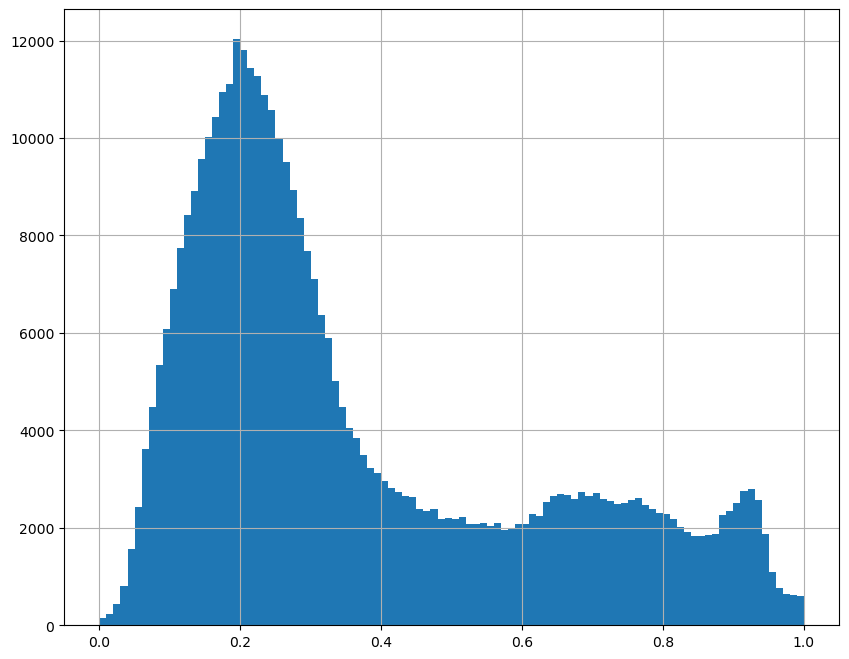

In [132]:
new_batch_stats.tmalign_score.hist(bins=100, figsize=(10,8));